# Quantifying Reconstruction Error
## Replicate tracings of a lamina cartridge

The reconstruction of each lamina circuit can broken down into three distinct steps

1. An annotator performs an initial dense reconstruction of an assigned cartridge: Every neurite contained within the cartridge is  labelling every synaptic connection indentified. A critical step of the initial reconstruction is the identification of a siginificant majority (~90%) of the cartridge's postsynaptic arbors by tracing 'backwards' from each unidentified neurite until the arbor connects to a known neuron. 
2. A different annotator will then perform a peer-review of the initial reconstruction. Each synaptic terminal associated with the cartridge is visited to ensure that post synaptic partners were labelled according to our criteria. 
3. Lastly, a senior member of the team will review the number of connection between all the neurons in the cartridge, along with the neuron's branch structure to determine if any outlying features are legittimate anomalies or the result of a skeletal tracing error. 

To quantify the observed variability in our connectome that could be explained by our reconstruction methodology, our four annotators performed replicate tracings of a previously untraced lamina cartridge. These replicates were produced independently before being subject to our review process outlined above. 

We observed that the variability of contact contact counts among different cartridges in our lamina connectome exceeds the variability we observe in our replicate experiment, where the same structure was reconstructed by different people. A significant source of variability between our replicates was the result of errors in skeletal representation, for example, a missing branch or a misattributed arbor. Depending on the length of skeleton missed or misattributed, these errors can cause significant outliers in the number of contacts observed for a particular type of connection. These errors were present both in our connectome and in our replicate experiment. Our analysis suggests that skeletal errors causing significant descripencies in contact counts are sufficiently mitigated by our review process. By reconstructing a series of stereotyped circuits, we can continuosly refer to our model to pinpoint potential skeletal errors, a task that is typically very difficult and inefficient to do naively (like finding a needle in a haystack). Once a discrepency is identified in either the individual circuit's adjacency matrix or dendrogram, we determine if the discrepency is an actual biological anomaly (which we have examples of) or the result of a mistake. Before performing a correction, we require both the identification of a point of failure (a location on the skeleton that crosses a membrane boundary into another cell) along with an alternative path that links the disconnected arbor to a known neurite without crossing any cell membranes. If we are certain a membrane was cross, but are unable to link the arbor to a known neurite, the arbor will be given an unidentified status, and factored into the cartridge's fraction of unidentified synaptic contacts.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import statsmodels.api as sm
from scipy.stats import sem, mannwhitneyu, kstest

from cx_analysis.fig_utils import hex_to_rgb
from cx_analysis.utils import yymmdd_today

from IPython.display import display, Math, Latex

In [2]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle')   # FIXME may not work if installled as a module

save_figs = False
fig_path = f'/mnt/home/nchua/Dropbox/lamina_figures/{yymmdd_today()}/{yymmdd_today()}'

In [3]:
# Lamina connectome
tp = '210809'  # '210615' is the most recent before duet/quartet grouping of R1-6
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
# Replicate 'validation' experiment 
val_tp = "200121"
val_data_path = f"~/Data/{val_tp}_exp2/{val_tp}_linkdf.pickle"
val_links = pd.read_pickle(val_data_path)

In [5]:
# Labels for different connection types, annotators, ommatidia
cell_types = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])
cell_types = [c for c in cell_types if c != 'UNKNOWN']
print(f"Data contains {len(cell_types)} identified cell types: {cell_types}")

cx_types = [p for p in itertools.product(cell_types, cell_types)]  
cx_type_labels = [f"{pre}->{post}" for pre, post in cx_types]

annotators = np.unique(val_links["pre_om"])
ommatidia = np.unique(lamina_links['pre_om'])

Data contains 11 identified cell types: ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N', 'R7', 'R7p', 'R8', 'R_duet', 'R_quartet', 'centri']


In [6]:
# Longform links converted to wide dataframe with cx_type columns
# cx counts from lamina connectome
df_lamina_all = pd.DataFrame(index=ommatidia, columns=cx_type_labels)
for om, row in df_lamina_all.iterrows():
    for c in cx_type_labels:
        pre_t, post_t = c.split('->')
        # Cartridges on the posterior edge lack L4, so their counts for these connections are NaNed 
        if om in ['B0', 'C1', 'E4', 'E5', 'E6', 'E7', 'D2'] and (post_t == 'LMC_4'):
            df_lamina_all.loc[om, c] = 0.0
        else:
            df_lamina_all.loc[om, c] = sum((lamina_links.pre_om == om) & (lamina_links.post_om == om) & 
                                           (lamina_links.pre_type == pre_t) & (lamina_links.post_type == post_t))

# cx counts from validation experiment
df_val_all = pd.DataFrame(index=annotators, columns=cx_type_labels)
for annot, row in df_val_all.iterrows():  # each annotator
    for c in cx_type_labels:
        pre_t, post_t = c.split('->')
        
        df_val_all.loc[annot, c] = sum((val_links.pre_om == annot) & (val_links.post_om == annot) & 
                                       (val_links.pre_type == pre_t) & (val_links.post_type == post_t))
  

### Define connection types to compare
- We use all connection types (n = celltypes**2)
- Other options:
    1. 'mean_thresh': Threshold by mean connection counts from the lamina connectome
    2. 'consistently_observed': Exclude connections not observed in every lamina cartridge

In [7]:
# Exclude connection types that have  mean count in the connectome < threshold
mean_thresh = 0.0
     
if mean_thresh > 0.0:
    included_cx = [cx for cx, mn in df_lamina_all.mean().items() if mn >= mean_thresh]
    df_lamina = df_lamina_all[included_cx]
    df_val = df_val_all[included_cx]
else:
    df_lamina = df_lamina_all
    df_val = df_val_all

included_n = len(df_val.columns)
assert(len(df_val.columns) == len(df_lamina.columns)) 
print(f"\n{included_n} connection types (out of a total possible {len(cx_type_labels)} pre/post permutations)")
print(f"Excluded: {len([cx for cx in cx_type_labels if cx not in list(df_val.columns)])}")


121 connection types (out of a total possible 121 pre/post permutations)
Excluded: 0


### Fano factor: a measure of dispersion for a set of observations
- For a given connection type (e.g. LMC_2 -> LMC_1), we have a set of observed connection counts dispersed around a mean value
- Because mean counts can differ significantly between types, we use Fano factor to describe a unitary deviation, scaled by the mean, that can be compared across connection types or aggregated to obtain an overall measure of dispersion in our data

$$D = \frac{\sigma^2}{\mu}$$

NOTE: Mean is not robust to outliers. Counts that are typically close to 0, but much higher because of a mistake in a particular observation, will have a very large fano factor. Ask mitya about using median for such a small n in our validation exp

Outliers are examined during a step of peer-review. When a connection count is much larger than the average or if a previously unobserved connection type is present, it is almost always due to a mistake in the skeletal reconstruction. 

In [8]:
def fano(df: pd.DataFrame) -> pd.Series:
    mean = df.mean()
    stadev = df.std(ddof=0)
    ff = pd.Series([(sd ** 2)/mn if mn > 0.0 else 0.0 for sd, mn in zip(stadev, mean)], index=mean.index)
    return ff

# Mann-Whitney *U* test (one-tailed)
**Null**: Connection counts drawn from the validation experiment have Fano factors that are *larger than or equal to* that of connection counts drawn from the connectome.   
**Alternative**: Connection counts drawn from the validation experiment have Fano factors that are *smaller* than that of connection counts drawn from the connectome. 

###### RESULTS ######
Test statistic, U = 3337.5, p-value =  1.89e-16
Reject null: fano factor of validation connection counts is smaller


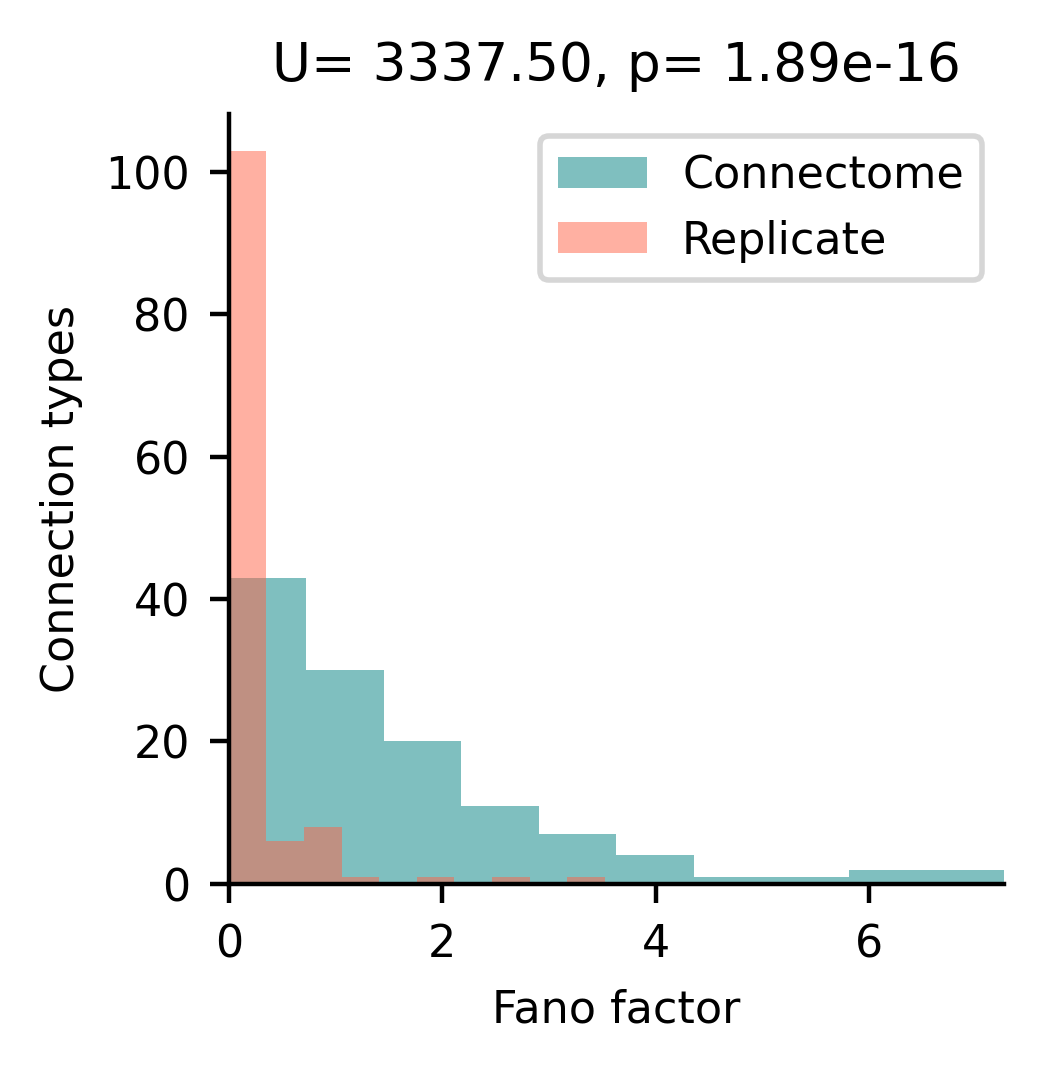

In [9]:
lamina_fano = fano(df_lamina)
val_fano = fano(df_val)

U, p = mannwhitneyu(val_fano, lamina_fano, alternative='less')
print("###### RESULTS ######")
print(f"Test statistic, U = {U}, p-value = {p: .2e}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: fano factor of validation connection counts is smaller")
#########################################################################################
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

ax.hist(lamina_fano, density=False, fc='teal', alpha=0.5, label='Connectome')
ax.hist(val_fano, density=False, fc='tomato', alpha=0.5, label='Replicate')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title(f'U={U: .2f}, p={p: .2e}')
ax.set_xlabel("Fano factor")
ax.set_ylabel("Connection types")
ax.set_xlim([0, max([lamina_fano.max(), val_fano.max()])])
ax.legend()

if save_figs:
    fname = f'methods_fano-utest-{included_n}cx'
    fig.savefig(fig_path + fname + '.svg')
    fig.savefig(fig_path + fname + '.png')

## Using standard error of the mean

n connection types = 121 and 121
###### RESULTS ######
Test statistic, U = 4491.5, p-value =  3.62e-09
Reject null: SEM of validation connection counts is smaller


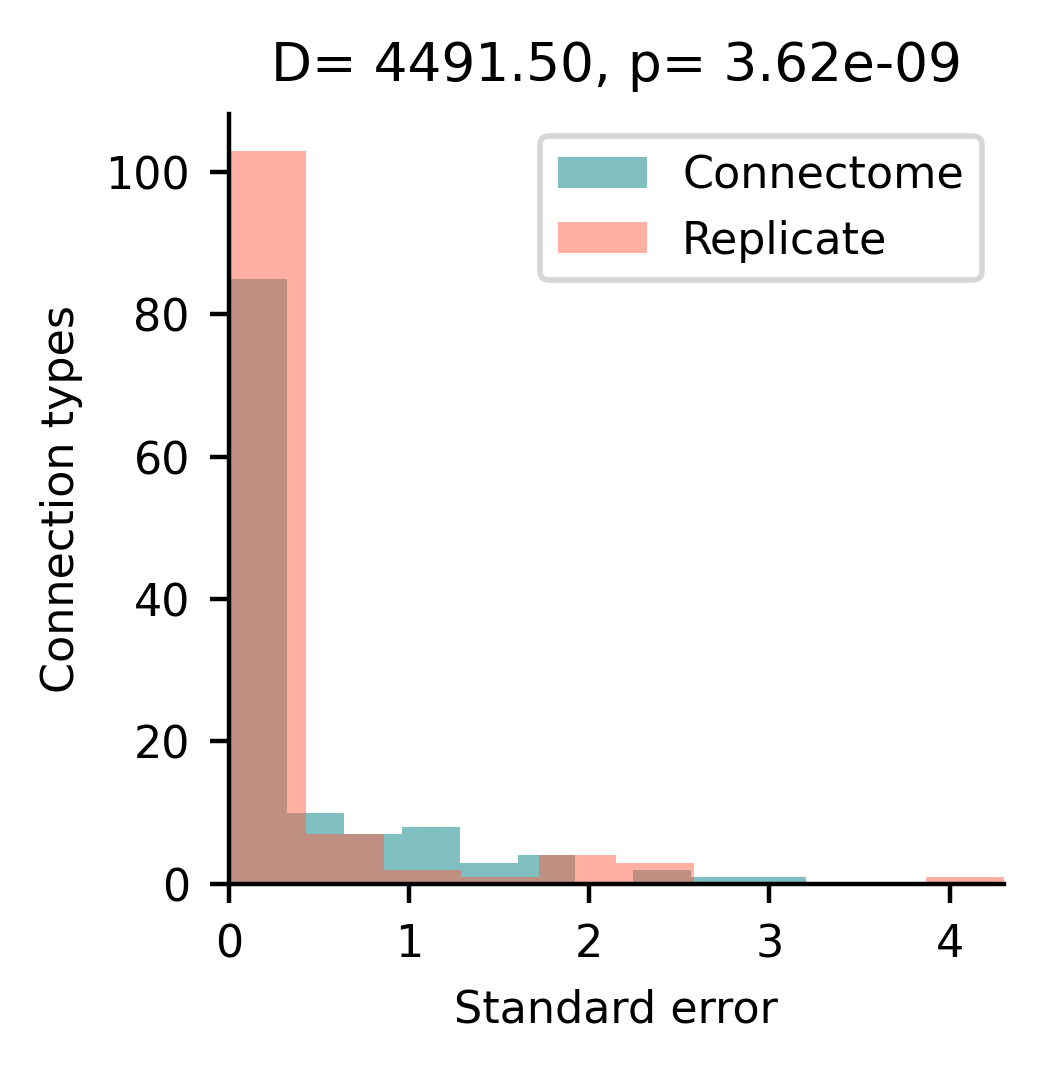

In [10]:
lamina_sem = sem(df_lamina.astype(float))
val_sem = sem(df_val.astype(float))

print(f"n connection types = {len(lamina_sem)} and {len(val_sem)}")

U, p = mannwhitneyu(val_sem, lamina_sem, alternative='less')
print("###### RESULTS ######")
print(f"Test statistic, U = {U}, p-value = {p: .2e}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: SEM of validation connection counts is smaller")
#####################################################################################
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

ax.hist(lamina_sem, density=False, fc='teal', alpha=0.5, label='Connectome')
ax.hist(val_sem, density=False, fc='tomato', alpha=0.5, label='Replicate')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title(f'D={U: .2f}, p={p: .2e}')
ax.set_xlabel("Standard error")
ax.set_ylabel("Connection types")
ax.set_xlim([0, max([lamina_sem.max(), val_sem.max()])])
ax.legend()

if save_figs:
    fname = f'methods_SEM-utest-{included_n}cx'
    fig.savefig(fig_path + fname + '.svg')
    fig.savefig(fig_path + fname + '.png')

# Kolmogorov-Smirnov Test
**Null**: Fano factor of connection counts in the validation experiment are drawn from the same distribution as those from the connectome data.  

0.5867768595041323

6.068189472820536e-20

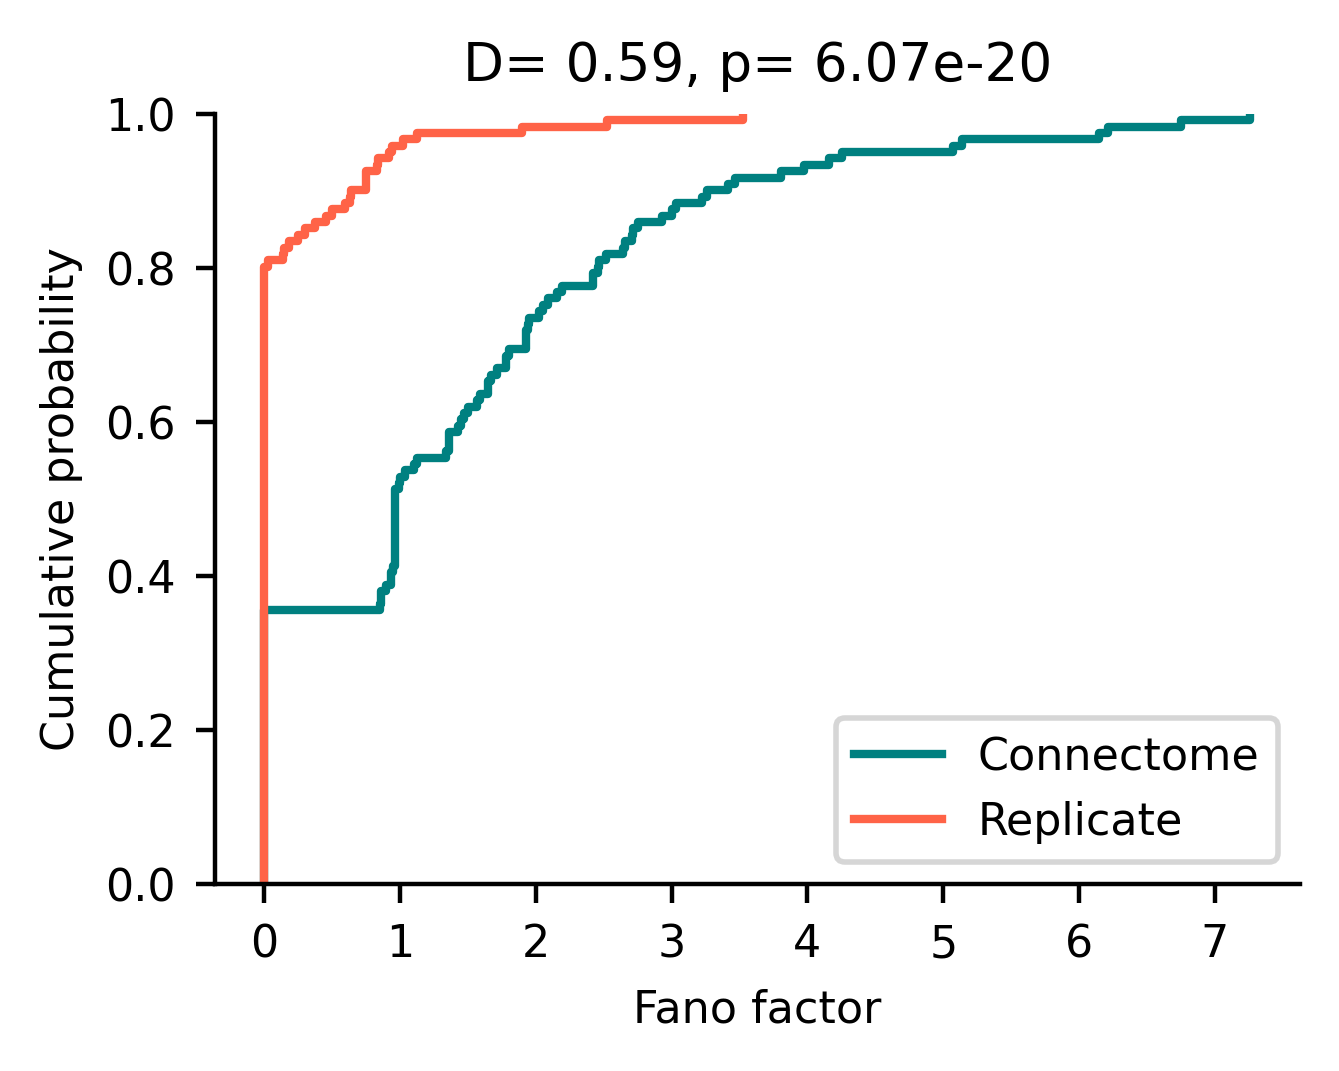

In [11]:
lamina_fano = fano(df_lamina)
val_fano = fano(df_val)

D, p = kstest(val_fano, lamina_fano, alternative='greater')

display(D)
display(p)
#####################################################################################
fig, ax = plt.subplots(1, figsize=[3.5, 2.5])

sns.ecdfplot(data=lamina_fano.T, ax=ax, label='Connectome', color='teal')
sns.ecdfplot(data=val_fano.T, ax=ax, label='Replicate', color='tomato')

ax.set_ylabel('Cumulative probability')
ax.set_xlabel('Fano factor')
ax.set_title(f'D={D: .2f}, p={p: .2e}')

ax.legend()

if save_figs:
    fname = f'methods_fano-kstest-{included_n}cx'
    fig.savefig(fig_path + fname + '.svg')
    fig.savefig(fig_path + fname + '.png')

0.4462809917355372

1.597605292652067e-11

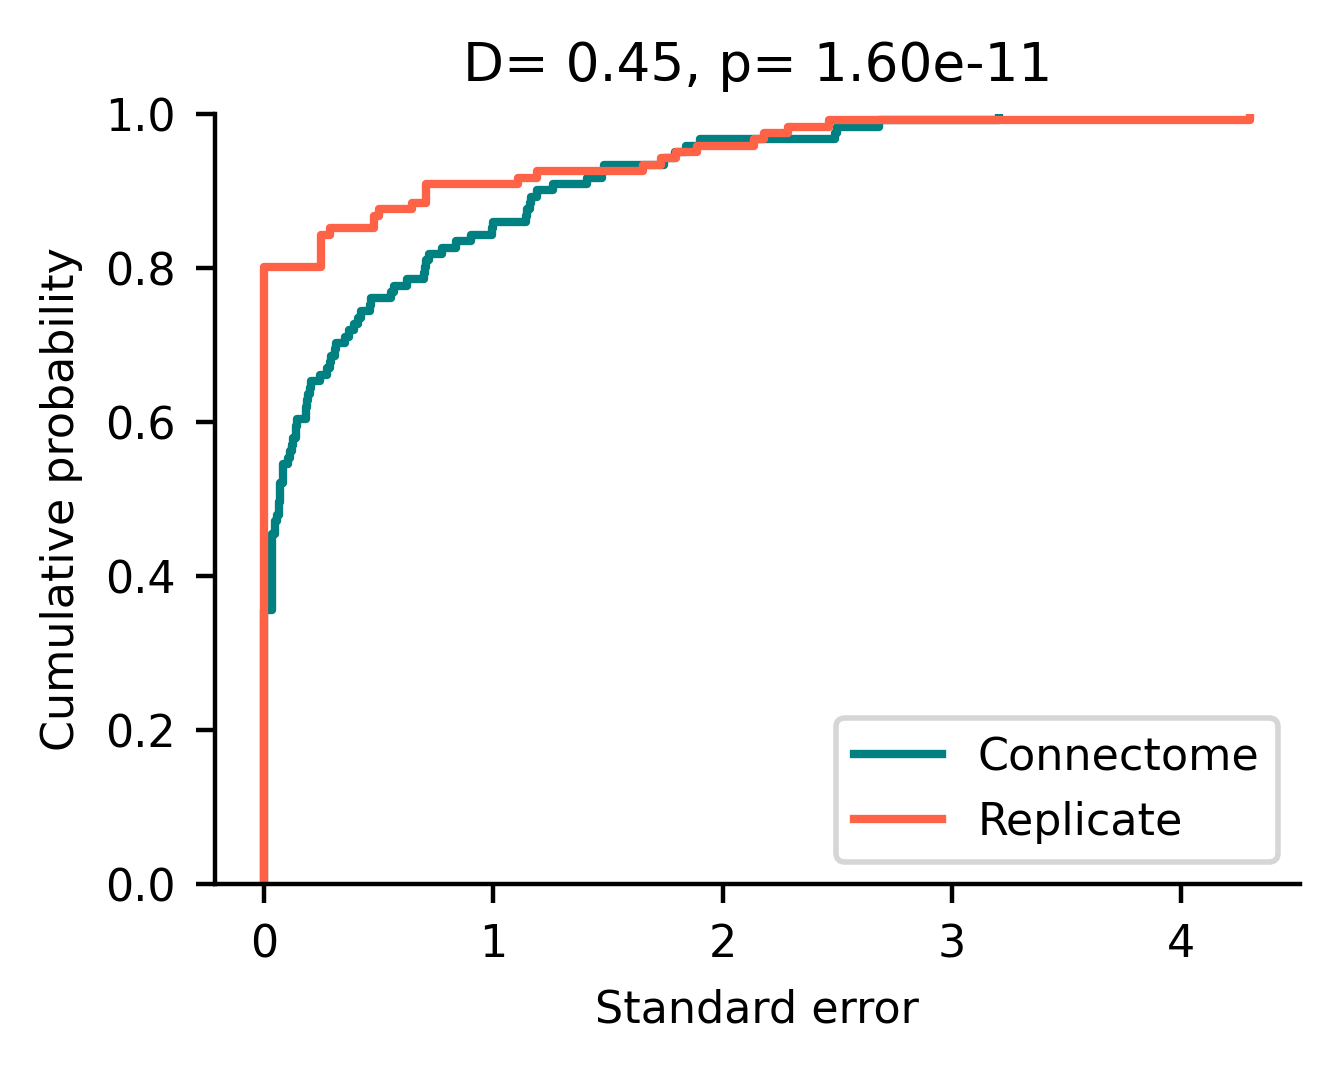

In [12]:
lamina_sem = sem(df_lamina.astype(float))
val_sem = sem(df_val.astype(float))

D, p = kstest(val_sem, lamina_sem, alternative='greater')

display(D)
display(p)
#####################################################################################
fig, ax = plt.subplots(1, figsize=[3.5, 2.5])

sns.ecdfplot(data=lamina_sem, ax=ax, label='Connectome', color='teal')
sns.ecdfplot(data=val_sem, ax=ax, label='Replicate', color='tomato')

ax.set_ylabel('Cumulative probability')
ax.set_xlabel('Standard error')
ax.set_title(f'D={D: .2f}, p={p: .2e}')

ax.legend(loc='lower right')

# if save_figs:
#     fname = f'methods_SEM-utest-{included_n}cx'
#     fig.savefig(fig_path + fname + '.svg')
#     fig.savefig(fig_path + fname + '.png')

0.4462809917355372

1.597605292652067e-11

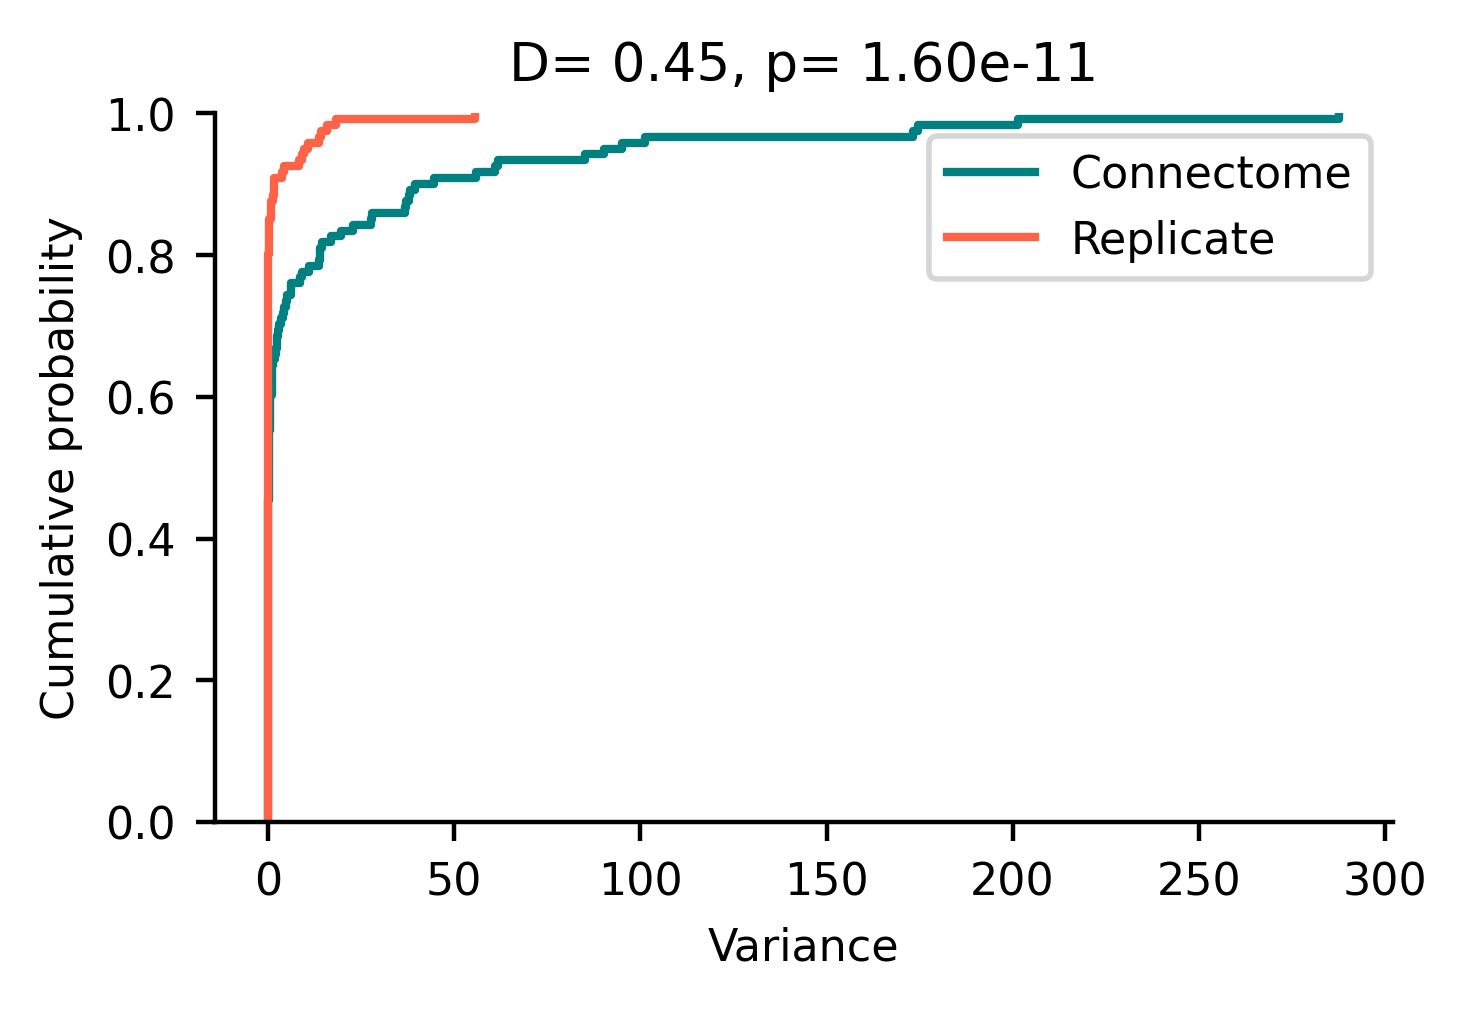

In [13]:
X = df_lamina.var(ddof=0)
Y = df_val.var(ddof=0)

D, p = kstest(Y, X, alternative='greater')

display(D)
display(p)
#####################################################################################
fig, ax = plt.subplots(1)

sns.ecdfplot(data=X, ax=ax, label='Connectome', color='teal')
sns.ecdfplot(data=Y, ax=ax, label='Replicate', color='tomato')

ax.set_ylabel('Cumulative probability')
ax.set_xlabel('Variance')
ax.set_title(f'D={D: .2f}, p={p: .2e}')

ax.legend()

# if save_figs:
#     fname = f'methods_variance-utest-{included_n}cx'
#     fig.savefig(fig_path + fname + '.svg')
#     fig.savefig(fig_path + fname + '.png')

In [14]:
def my_OLS(Y, X, fit_intercept=True, show_summary=True):
    
    if fit_intercept:
        X = sm.add_constant(X)
        
    model = sm.OLS(Y, X)
    results = model.fit()
    
    model = {**results.params, 'rsquared': results.rsquared, 'f_pvalue': results.f_pvalue}
    if show_summary:
        display(results.summary())
        
    return model
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     379.8
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           7.74e-39
Time:                        19:58:47   Log-Likelihood:                -537.13
No. Observations:                 121   AIC:                             1078.
Df Residuals:                     119   BIC:                             1084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6991      2.027      0.345      0.731      -3.314       4.712
0              2.7868      0.143     19.489      0.000       2.504       3.070
==============================================================================
Omnibus:                       84.672   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.742
Skew:                           2.157   Prob(JB):                    1.25e-192
Kurtosis:                      15.517   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     173.5
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           5.38e-25
Time:                        19:58:47   Log-Likelihood:                -331.89
No. Observations:                 121   AIC:                             667.8
Df Residuals:                     119   BIC:                             673.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0412      0.362     -0.114      0.910      -0.758       0.676
0              0.9717      0.074     13.174      0.000       0.826       1.118
==============================================================================
Omnibus:                      181.819   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16698.081
Skew:                           5.570   Prob(JB):                         0.00
Kurtosis:                      59.462   Cond. No.                         5.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

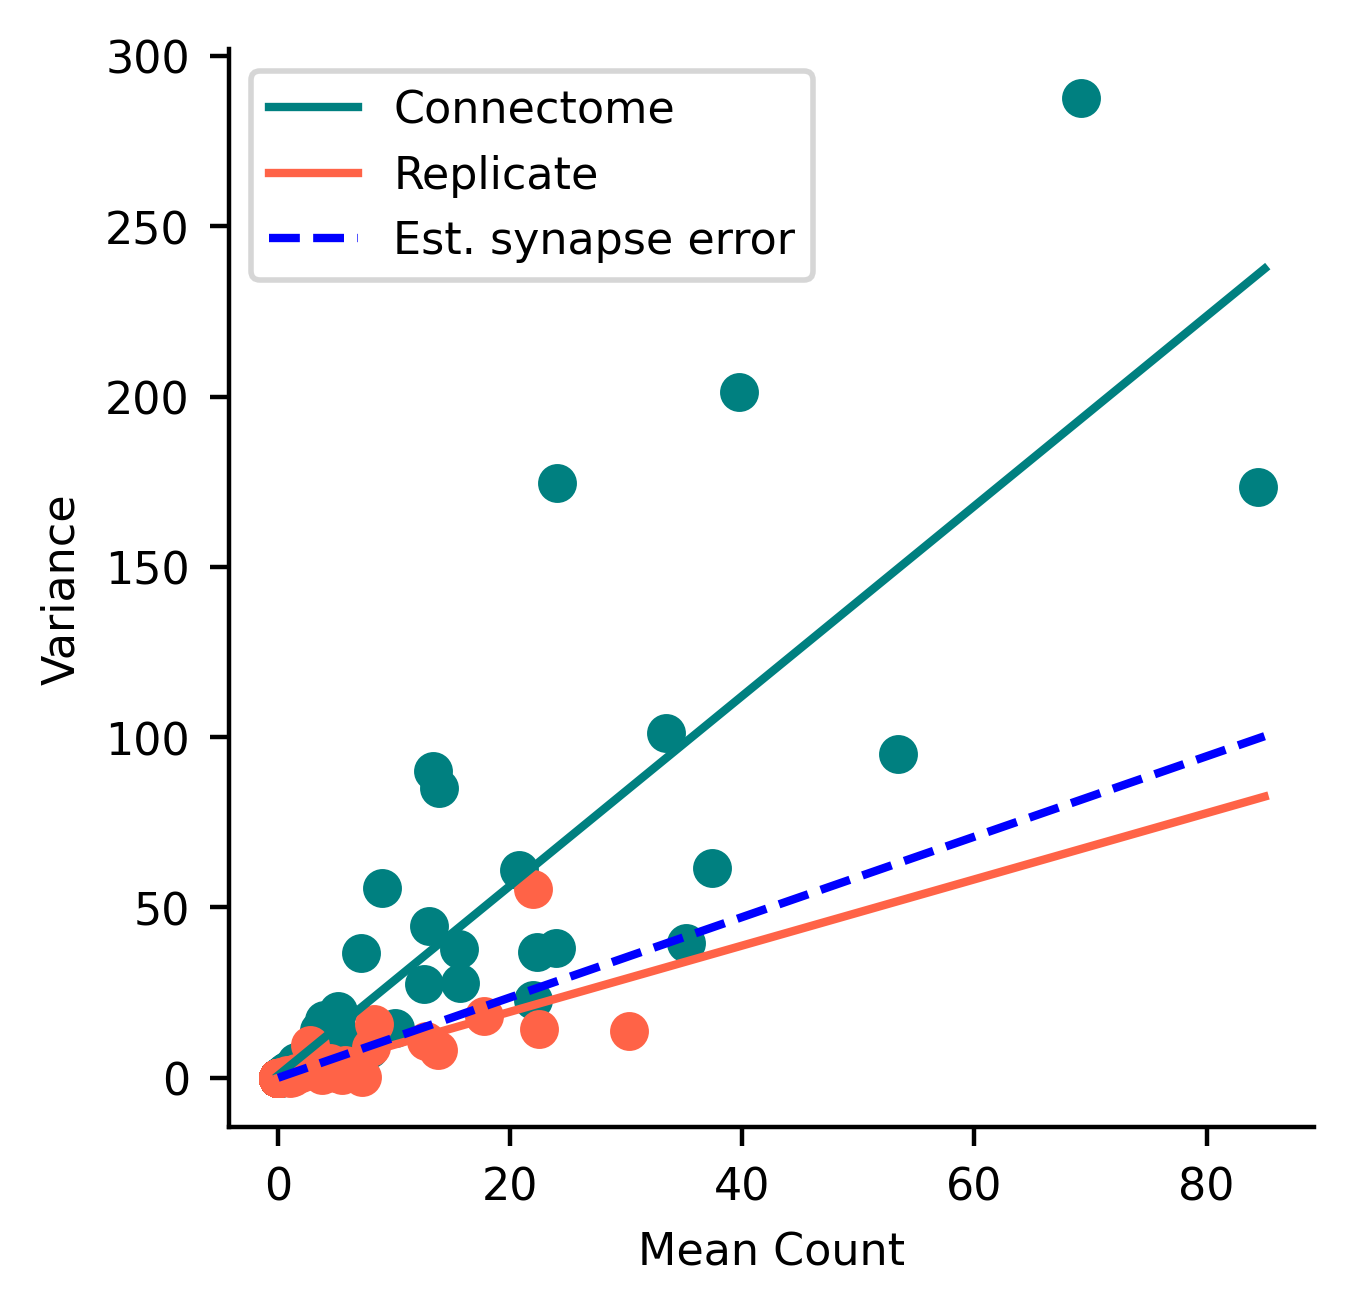

In [15]:
fig, ax = plt.subplots(1, figsize=[3.5, 3.5])
xticks = np.arange(0, max((df_lamina.mean().max(), df_val.mean().max())) + 1).T

#ax.set_xlim(0, max((df_lamina.mean().max(), df_val.mean().max())) + 5)
#ax.set_ylim(0, max((df_lamina.var().max(), df_val.var().max())) + 5)

# Connectome
model = my_OLS(df_lamina.var(ddof=0), df_lamina.mean())
ax.plot(xticks, model['const'] + model[0] * xticks, color='teal', label='Connectome')
ax.scatter(df_lamina.mean(), df_lamina.var(ddof=0), color='teal')
# Validation
model = my_OLS(df_val.var(ddof=0), df_val.mean())
ax.plot(xticks, model['const'] + model[0] * xticks, color='tomato', label='Replicate')
ax.scatter(df_val.mean(), df_val.var(ddof=0), color='tomato')

ax.plot(xticks, xticks*1.18, '--', color='b', label='Est. synapse error')
#ax.plot(xticks, xticks, '--', label='Poisson noise (x=y)')

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('Mean Count')
ax.set_ylabel('Variance')
ax.legend()

if save_figs:
    fname = f'methods_mean-vs-variance_{included_n}cx'
    fig.savefig(fig_path + fname + '.svg')
    fig.savefig(fig_path + fname + '.png')